In [28]:
import tskit
import numpy as np

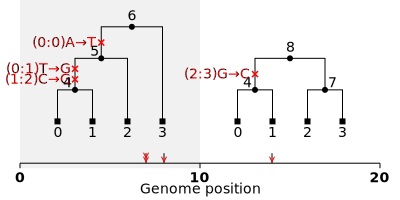

In [29]:
ts = tskit.load("../trees/case2.tree")
# ts = tskit.load("../tree-simple-1.tree")
# ts = tskit.load("../test.tree")

mut_labels = {}  # An array of labels for the mutations
for mut in ts.mutations():  # Make pretty labels showing the change in state
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"({mut.site}:{mut.id}){prev}→{mut.derived_state}"

ts.draw_svg(mutation_labels=mut_labels)

In [18]:
def union_sample_arrays(a, b, num_sample_chunks):
    out = np.zeros(num_sample_chunks, dtype=np.uint64)
    if a == 0 and b == 0:
        return out
    for i in range(num_sample_chunks):
        out[i] = a[i] & b[i]
    return out

def subtract_sample_arrays(a, b, num_sample_chunks):
    # NB modifies a in place
    # essentially, a -= b
    if b == 0:
        return
    for i in range(num_sample_chunks):
        a[i] &= ~(b[i])

def add_sample_arrays(a, b, num_sample_chunks):
    # NB modifies a in place
    # essentially, a += b
    if b == 0:
        return
    for i in range(num_sample_chunks):
        a[i] |= b[i]

BITMASK_CHUNK_SIZE = np.uint64(64)
ONE = np.uint64(1)
def add_samples_to_array(a, samples):
    for s in samples:
        i = s // BITMASK_CHUNK_SIZE
        a[i] |= ONE << (s - (BITMASK_CHUNK_SIZE * i))

def add_sample_to_array(a, s):
    i = s // BITMASK_CHUNK_SIZE
    a[i] |= ONE << (s - (BITMASK_CHUNK_SIZE * i))

def count_bits(a):
    # https://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetNaive
    count = np.uint8(0)
    while a:
        a &= a - np.uint8(1)
        count += np.uint8(1)
    return count

def number_of_samples_in_array(a, num_sample_chunks):
    total = 0
    for s in range(num_sample_chunks):
        total += count_bits(a[s])
    return total

def get_samples_from_array(a, num_sample_chunks):
    for i in range(num_sample_chunks):
        for s in np.arange(BITMASK_CHUNK_SIZE, dtype=np.uint64):
            if a[i] & (ONE << s):
                yield s

# st = np.zeros((150, len(sample_sets), (100 // 64) + 1), dtype=np.uint64)
# for ss in range(len([np.arange(100, dtype=np.uint64)])):
#     for s in [np.arange(100, dtype=np.uint64)][ss]:
#         add_samples_to_array(st[s, ss], [s])

In [19]:
def pairs_with_replacement(n):
    subloop_start = 0
    for i in range(n):
        for j in range(subloop_start, n):
            yield i, j
        subloop_start += 1

In [20]:
def next_state_at(ts, tj, tk, t_left, sample_sets, parent=None, state=None):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order

    parent = -np.ones(ts.num_nodes, dtype=np.int32) if parent is None else parent
    state = np.zeros((ts.num_nodes, len(sample_sets), (int(ts.num_samples // BITMASK_CHUNK_SIZE)) + 1), dtype=np.uint64) if state is None else state
    state_dim = state.shape[1]  # number of sample sets
    num_bitmask_chunks = state.shape[2]

    for k in range(state_dim):
        for sample_node in sample_sets[k]:
            add_samples_to_array(state[sample_node, k], [sample_node])

    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        while (v != -1):
            for k in range(state_dim):
                subtract_sample_arrays(state[v, k], state[u, k], num_bitmask_chunks)
            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            for k in range(state_dim):
                add_sample_arrays(state[v, k], state[u, k], num_bitmask_chunks)
            v = parent[v]
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])

    t_left = t_right
    return tj, tk, t_left, parent, state

In [21]:
def get_allele_samples(state, site, sample_sets):
    allele_state = np.zeros((len(site.mutations) + 1, len(sample_sets), (int(ts.num_samples // BITMASK_CHUNK_SIZE)) + 1), dtype=np.uint64)
    alleles = [site.ancestral_state]
    num_alleles = 1

    # TODO: total weight
    for k in range(len(sample_sets)):
        add_samples_to_array(allele_state[0, k], sample_sets[k])

    for mutation in site.mutations:
        if mutation.derived_state in alleles:
            allele = alleles.index(mutation.derived_state)
        else:
            alleles.append(mutation.derived_state)
            allele = len(alleles) - 1
            num_alleles += 1

        for k in range(len(sample_sets)):
            add_sample_arrays(allele_state[allele, k], state[mutation.node, k], allele_state.shape[1])

        alt_allele = alleles.index(site.ancestral_state)
        if mutation.parent != -1:
            # TODO haven't exercised this code path yet
            alt_allele = alleles.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
        for k in range(len(sample_sets)):
            subtract_sample_arrays(allele_state[alt_allele, k], state[mutation.node, k], allele_state.shape[1])
    return num_alleles, allele_state

In [22]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
# sample_sets = [[0, 1, 2]]
sample_sets = [list(ts.samples())]
sample_sets = np.array(sample_sets, dtype=np.uint64)

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

tj_right = 0
tk_right = 0
t_left_right = 0
tree_index_right = 0
parent_right = None
state_right = None

last = False

while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    treeseq_state_left = next_state_at(
        ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
        sample_sets=sample_sets, parent=parent_left, state=state_left,
    )
    tj_left, tk_left, t_left_left, parent_left, state_left = treeseq_state_left
    tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_left
    parent_right = parent_right.copy()
    state_right = state_right.copy()

    tree_index_right = tree_index_left

    if (tj_right >= ts.num_edges) or (t_left_right >= ts.sequence_length):  # TODO: there must be a better way to do this.
        last = True

    while (tj_right < ts.num_edges) or (t_left_right < ts.sequence_length) or last:
        if tree_index_left != tree_index_right:  # TODO: there must be a better way to do this.
            treeseq_state_right = next_state_at(
                ts=ts, tj=tj_right, tk=tk_right, t_left=t_left_right,
                sample_sets=sample_sets, parent=parent_right, state=state_right,
            )
            tj_right, tk_right, t_left_right, parent_right, state_right = treeseq_state_right

        num_sites_left = ts.at_index(tree_index_left).num_sites  # ts->tree_sites_len[tree_index_left]
        num_sites_right = ts.at_index(tree_index_right).num_sites
        sites_left = list(ts.at_index(tree_index_left).sites())  # ts->tree_sites[tree_index_left]
        sites_right = list(ts.at_index(tree_index_right).sites())

        if tree_index_left != tree_index_right:
            for i in range(num_sites_left):
                for j in range(num_sites_right):
                    site_left = sites_left[i]
                    site_right = sites_right[j]
                    
                    len_s_1, s_1 = get_allele_samples(state_left, site_left, sample_sets)
                    len_s_2, s_2 = get_allele_samples(state_right, site_right, sample_sets)
                    hap_matrix = np.zeros((len_s_1, len_s_2), dtype=np.uint32)
                    for i in range(len_s_1):
                        for j in range(len_s_2):
                            hap_matrix[i, j] = number_of_samples_in_array(union_sample_arrays(s_1[i, 0], s_2[j, 0], 1), 1)
                    print('trees: ', tree_index_left, tree_index_right, 'sites: ', site_left.id, site_right.id)
                    print(hap_matrix)
                    # raise Exception
        else:
            assert num_sites_left == num_sites_right
            for i, j in pairs_with_replacement(num_sites_left):
                site_left = sites_left[i]
                site_right = sites_right[j]
                len_s_1, s_1 = get_allele_samples(state_left, site_left, sample_sets)
                len_s_2, s_2 = get_allele_samples(state_right, site_right, sample_sets)
                hap_matrix = np.zeros((len_s_1, len_s_2), dtype=np.uint32)
                for i in range(len_s_1):
                    for j in range(len_s_2):
                        hap_matrix[i, j] = number_of_samples_in_array(union_sample_arrays(s_1[i, 0], s_2[j, 0], 1), 1)
                print('trees: ', tree_index_left, tree_index_right, 'sites: ', site_left.id, site_right.id)
                print(hap_matrix)
        if last:
            break
        tree_index_right += 1
    tree_index_left += 1

trees:  0 0 sites:  0 0
[[1 0 0]
 [0 1 0]
 [0 0 2]]
trees:  0 0 sites:  0 1
[[1 0]
 [1 0]
 [0 2]]
trees:  0 0 sites:  1 1
[[2 0]
 [0 2]]
trees:  0 1 sites:  0 2
[[1 0]
 [1 0]
 [0 2]]
trees:  0 1 sites:  1 2
[[2 0]
 [0 2]]
trees:  1 1 sites:  2 2
[[2 0]
 [0 2]]


In [27]:
for i in state_left.reshape(-1):
    print(bin(i))

0b1
0b10
0b100
0b1000
0b11
0b0
0b0
0b1100
0b1111


In [16]:
from two_locus_proto.site import two_site_general_stat
from two_locus_proto.summary_functions import r2

In [ ]:
two_site_general_stat(ts, r2, 'total', False,debug=True)

hap_mat
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]
stats
[[1.         0.11111111 0.33333333]
 [0.11111111 1.         0.33333333]
 [0.33333333 0.33333333 1.        ]]
weights
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
hap_mat
[[1. 1. 0.]
 [0. 0. 2.]]
stats
[[0.33333333 0.33333333 1.        ]
 [0.33333333 0.33333333 1.        ]]
weights
[[0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667]]
hap_mat
[[1. 1. 0.]
 [0. 0. 2.]]
stats
[[0.33333333 0.33333333 1.        ]
 [0.33333333 0.33333333 1.        ]]
weights
[[0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667]]
hap_mat
[[2. 0.]
 [0. 2.]]
stats
[[1. 1.]
 [1. 1.]]
weights
[[0.25 0.25]
 [0.25 0.25]]
hap_mat
[[2. 0.]
 [0. 2.]]
stats
[[1. 1.]
 [1. 1.]]
weights
[[0.25 0.25]
 [0.25 0.25]]
hap_mat
[[2. 0.]
 [0. 2.]]
stats
[[1. 1.]
 [1. 1.]]
weights
[[0.25 0.25]
 [0.25 0.25]]


array([[0.50617284, 0.55555556, 0.55555556],
       [0.55555556, 1.        , 1.        ],
       [0.55555556, 1.        , 1.        ]])

In [8]:
for n in range(len(state_left)):
    print(list(get_samples_from_array(state_left[n, 0], 1)))

[0]
[1]
[2]
[3]
[0, 1]
[]
[]
[2, 3]
[0, 1, 2, 3]


In [9]:
for n in range(len(state_left)):
    print(list(get_samples_from_array(state_right[n, 0], 1)))

[0]
[1]
[2]
[3]
[0, 1]
[]
[]
[2, 3]
[0, 1, 2, 3]


In [10]:
len_s_1, s_1 = get_allele_samples(state_left, site_left, sample_sets)

In [11]:
print(len_s_1)
for i in range(len_s_1):
    print(list(get_samples_from_array(s_1[i, 0], 1)))

2
[2, 3]
[0, 1]


In [12]:
len_s_2, s_2 = get_allele_samples(state_right, site_right, sample_sets)

In [13]:
print(len_s_2)
for i in range(len_s_2):
    print(list(get_samples_from_array(s_2[i, 0], 1)))

2
[2, 3]
[0, 1]


In [14]:
hap_matrix = np.zeros((len_s_1, len_s_2), dtype=np.uint32)
for i in range(len_s_1):
    for j in range(len_s_2):
        hap_matrix[i, j] = number_of_samples_in_array(union_sample_arrays(s_1[i, 0], s_2[j, 0], 1), 1)

In [15]:
hap_matrix

array([[2, 0],
       [0, 2]], dtype=uint32)